In [1]:
import Spectrogram
from librosa.core import note_to_hz, cqt
from librosa import filters
import numpy as np
import matplotlib.pyplot as plt
from time import time

import torch

In [2]:
# parameters
# nargin = 6
bins = 12 # bins per octave
fs = 22050 # sampling rate
n_bins = 80
# fmax = 61.73541266 # same as 1 octave
# fmax = 880*2
fmin = note_to_hz('C1')
thresh= 0.0054

stride = 512

s = np.linspace(0,10,fs*10)
x = np.sin(2*np.pi*100*s, dtype=np.float32) + np.sin(2*np.pi*200*s, dtype=np.float32) \
    + np.sin(2*np.pi*800*s, dtype=np.float32) + np.sin(2*np.pi*1600*s, dtype=np.float32)  

In [3]:
def cqt_filter_fft(sr, fmin, n_bins, bins_per_octave, tuning,
                     filter_scale, norm, sparsity, hop_length=None,
                     window='hann'):
    '''Generate the frequency domain constant-Q filter basis.'''

    basis, lengths = filters.constant_q(sr,
                                        fmin=fmin,
                                        n_bins=n_bins,
                                        bins_per_octave=bins_per_octave,
                                        tuning=tuning,
                                        filter_scale=filter_scale,
                                        norm=norm,
                                        pad_fft=True,
                                        window=window)

    # Filters are padded up to the nearest integral power of 2
    n_fft = basis.shape[1]

    if (hop_length is not None and
            n_fft < 2.0**(1 + np.ceil(np.log2(hop_length)))):

        n_fft = int(2.0 ** (1 + np.ceil(np.log2(hop_length))))

    # re-normalize bases with respect to the FFT window length
    basis *= lengths[:, np.newaxis] / float(n_fft)

    # FFT and retain only the non-negative frequencies
    fft = get_fftlib()
    fft_basis = fft.fft(basis, n=n_fft, axis=1)[:, :(n_fft // 2)+1]

    # sparsify the basis
    fft_basis = util.sparsify_rows(fft_basis, quantile=sparsity)

    return fft_basis, n_fft, lengths, basis

# Pytorch

In [4]:
start = time()
CQT_layer = Spectrogram.CQT1992(fs, stride, fmin, fmax=None, n_bins=n_bins,
                        bins_per_octave=bins, norm=None,center=True,
                        pad_mode='reflect')
print("Time used to initialize CQT kernels = ", time()-start)

Time used to initialize CQT kernels =  0.10390377044677734
Time used to initialize FFT kernels = 12.39635968208313, n_fft = 16384
Time used to initialize CQT kernels =  12.537390232086182


In [5]:
CQT_layer2 = Spectrogram.CQT2010(fs, stride, fmin, fmax=None, n_bins=n_bins,
                        bins_per_octave=bins,center=True,
                        pad_mode='reflect', earlydownsample=False)

Getting arg done
keyFrequencies =  [0.0, 0.4995004995004996, 0.5005, 1.0]
Getting lowpass_filter done
Getting cqt kernel done, n_fft =  256
Getting FFT kernel done


In [6]:
cqt_torch = CQT_layer(torch.tensor(x))

In [7]:
cqt_torch2 = CQT_layer2(torch.tensor(x))

downsample True or not? False
First CQT done
0
torch.Size([1, 1, 110250])
1
torch.Size([1, 1, 55125])
2
torch.Size([1, 1, 27562])
3
torch.Size([1, 1, 13781])
4
torch.Size([1, 1, 6890])
5
torch.Size([1, 1, 3445])


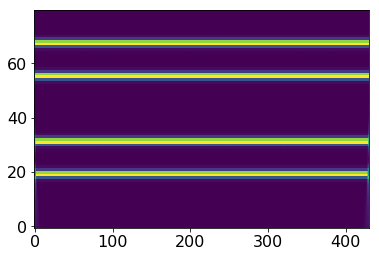

In [8]:
plt.imshow(cqt_torch[0].numpy(),aspect='auto', origin='lower')
plt.tick_params(labelsize=16)

# Librosa

In [9]:
from librosa.core import cqt

In [10]:
cqt_lib = cqt(x, fs, stride, fmin, n_bins=n_bins,
              bins_per_octave=bins, norm=None)

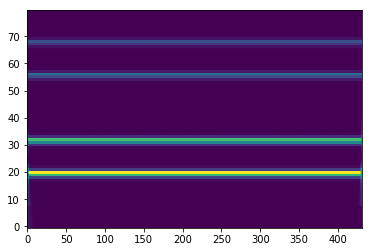

In [11]:
plt.imshow(abs(cqt_lib),aspect='auto', origin='lower')

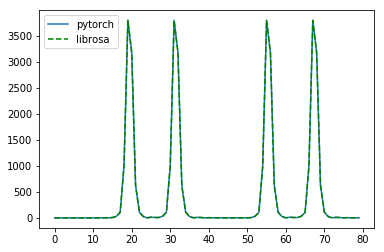

In [12]:
plt.plot(cqt_torch[0].numpy()[:,29])
# plt.plot(abs(cqt_lib)[:,29], 'r--')
plt.plot(cqt_torch2[0].numpy()[:,29], 'g--')
plt.legend(['pytorch', 'librosa'])